In [1]:
%pylab notebook
from pandas import Timedelta
from pandas import *
rcParams['axes.grid'] = True
from struct import unpack

Populating the interactive namespace from numpy and matplotlib


In [29]:
vals = genfromtxt('velo1.csv', dtype=int, delimiter=',')

In [30]:
# numpy array to pandas dataframe
tss = to_datetime(vals[:, 0], unit='s', utc=True).tz_convert('US/Pacific')
df = DataFrame(vals, index=tss, columns=('ts', 'mV', 'mA', 'cnt'))
df

,ts,mV,mA,cnt
2020-10-26 00:33:20-07:00,1603697600,7232,-55,6487
2020-10-26 00:33:21-07:00,1603697601,7232,-53,6487
2020-10-26 00:33:22-07:00,1603697602,7232,-32,6487
2020-10-26 00:33:23-07:00,1603697603,7240,-28,6493
2020-10-26 00:33:24-07:00,1603697604,7240,-26,6501
...,...,...,...,...
2020-10-27 19:45:35-07:00,1603853135,7292,-14,63934
2020-10-27 19:45:36-07:00,1603853136,7292,-14,63934
2020-10-27 19:45:37-07:00,1603853137,7292,-14,63934
2020-10-27 19:45:38-07:00,1603853138,7292,-14,63934


<IPython.core.display.Javascript object>


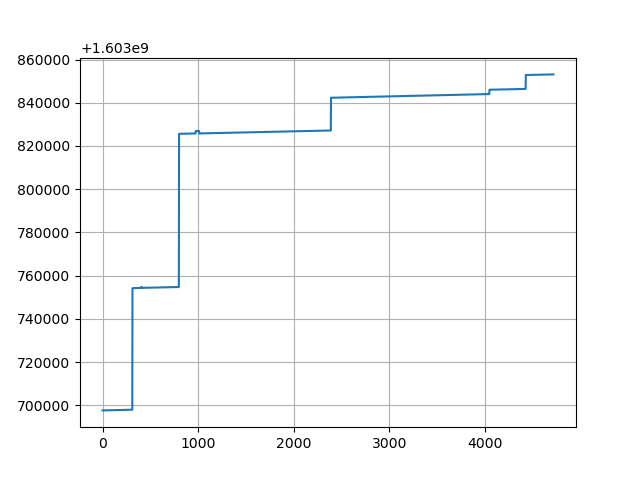

In [31]:
plot(df['ts'].values)

# Crop and clean up data

In [32]:
# Sort by timestamp
dff = df.sort_index()

# Crop trash data at beginning
filter_inds = dff.index < Timestamp('2020-10-18 18:59:00-0700')
filter_inds |= dff.index > Timestamp('2030-10-18 18:59:00-0700')
print(sum(filter_inds))

# filter out duplicates (identical timestamps)
filter_inds |= dff.ts.diff() == 0
print(f"Filtering out {sum(filter_inds)} values")
print(sum(filter_inds))

dff = dff[~filter_inds]

conv = 165769 / 1000 / 1000 # pulse to meter
dff['kmh'] = (dff['cnt'].diff() / dff.ts.diff() * conv * 60 * 60 / 1000)
dff['km'] = (dff['cnt'] - dff['cnt'].iloc[0]) * conv / 1000

0
Filtering out 46 values
46


<IPython.core.display.Javascript object>


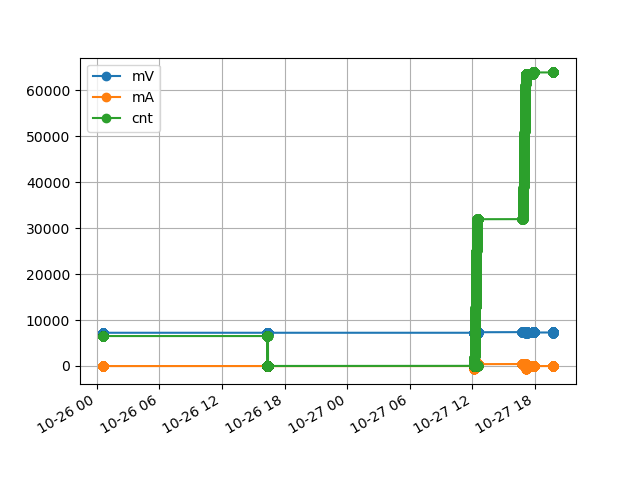

<AxesSubplot:>

In [33]:
close()
dff[['mV', 'mA', 'cnt']].plot(marker='o')

In [111]:
lms = {
    'mA': (-750, 750, 'Battery current [mA]'),
    'mV': (5000, 9000, 'Battery voltage [mV]'),
    'cnt': (-10, 100000, 'Wheel counter'),
    'kmh': (-5, 50, 'Speed [km/h]'),
    'km': (0, 10000, 'Distance [km]')
}

def veloplt(cols=['mA'], **kwargs):
    close()
    fig, axs = subplots(len(cols), 1, sharex=True, figsize=(9, 7))
    
    for i, col in enumerate(cols):
        dff[col].plot(ax=axs[i], marker='o', **kwargs)
        if col in lms:
            axs[i].set_ylim(lms[col][:2])
            axs[i].set_ylabel(lms[col][2])
        
    for ax in axs:
        ax.legend()
    
    # show the last 6 h
    ts_l = dff.index[-1]
    ax.set_xlim(left=ts_l - Timedelta(hours=6), right=ts_l + Timedelta(minutes=5))

    fig.tight_layout()
    return axs

# Trip to Berkeley Bowl and back
Switching off the headlight at `19:10:30`

<IPython.core.display.Javascript object>


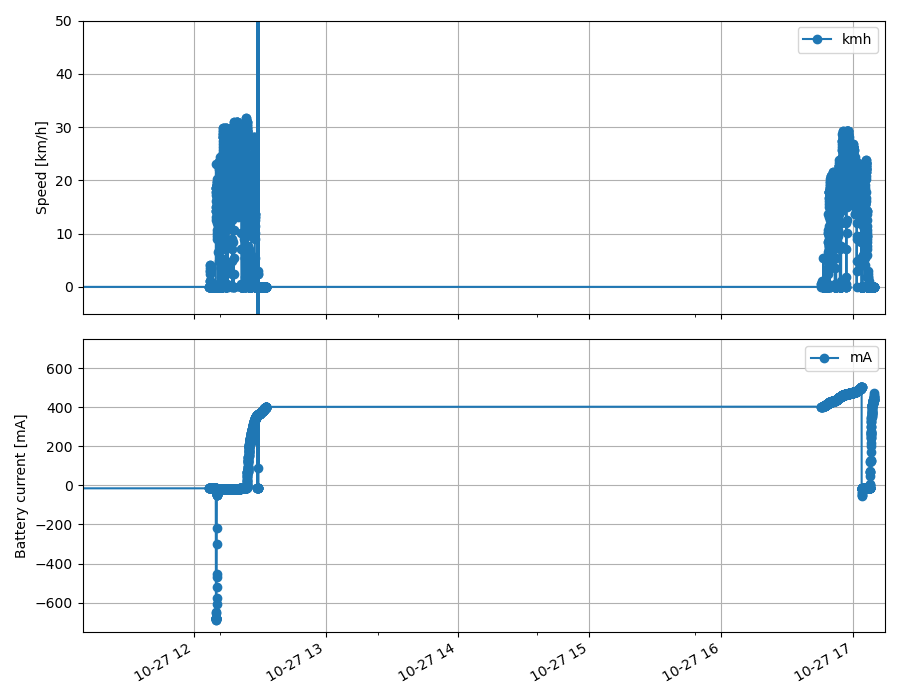

In [112]:
axs = veloplt(('kmh', 'mA'))

<IPython.core.display.Javascript object>


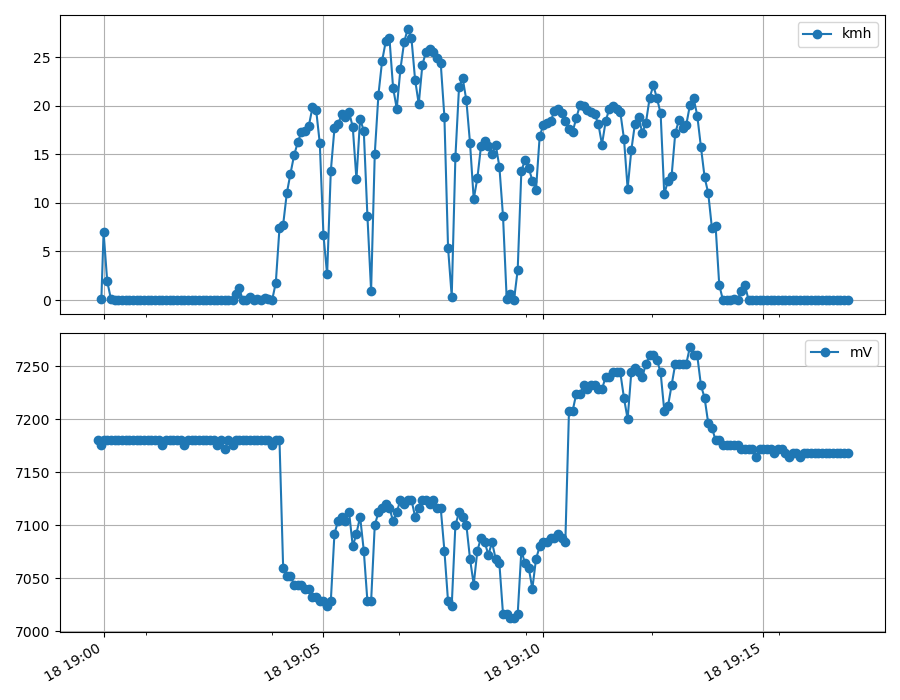

In [7]:
veloplt('kmh', 'mV')

<IPython.core.display.Javascript object>


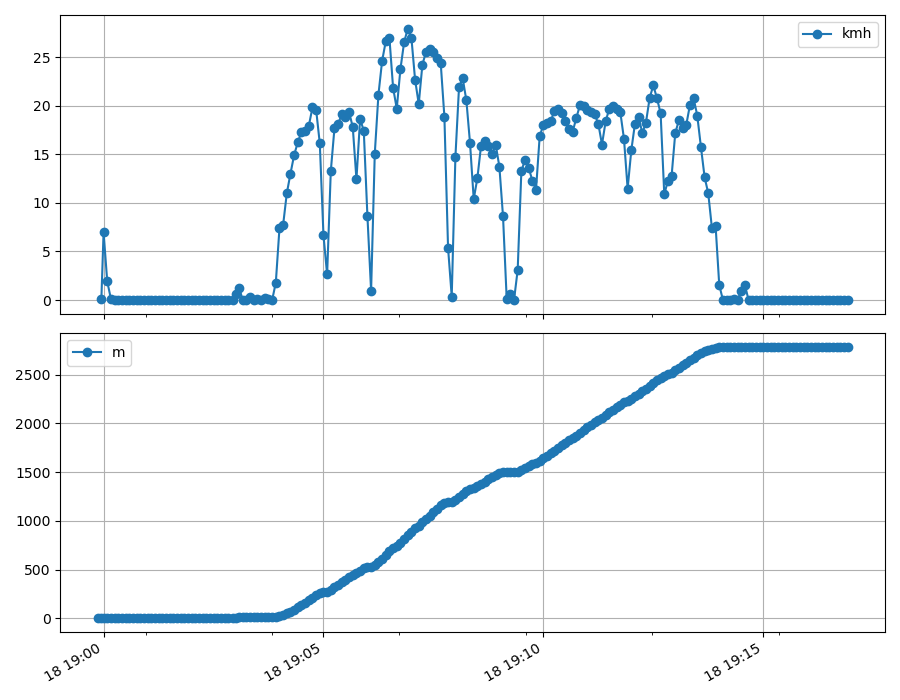

In [10]:
veloplt('kmh', 'm')

<IPython.core.display.Javascript object>


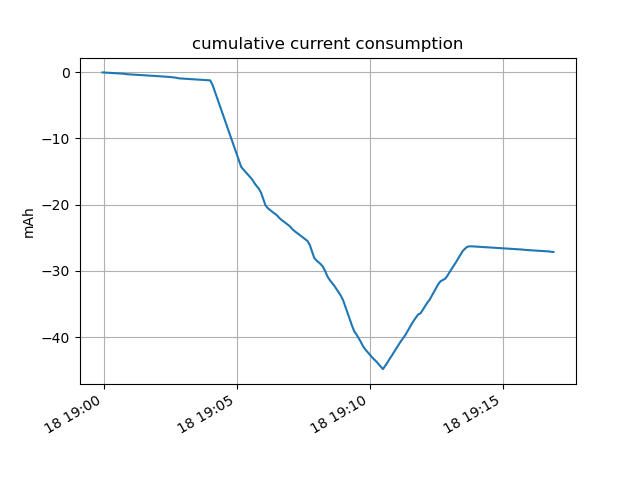

Text(0, 0.5, 'mAh')

In [11]:
close()
(dff['mA'] * dff.ts.diff() / 60 / 60).cumsum().plot()
title('cumulative current consumption')
ylabel('mAh')

In [12]:
trapz(dff['mA'], dff['ts']) / 60 / 60

-27.153333333333332